<a href="https://colab.research.google.com/github/Horgas/TS_SRGAN/blob/main/TS_SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set()
from mpl_toolkits import mplot3d
from sklearn.model_selection import train_test_split

In [ ]:
# for _ in range(20):
#   a, b, c = np.random.normal(loc=0, scale=10, size=3)
#   print(a,b,c)

In [ ]:
# def pixel_shuffle_1d(input, upscale_factor):
#     batch_size, channels, in_length = input.size()
#     channels //= upscale_factor

#     # Reshape data
#     input_view = input.contiguous().view(batch_size, channels, upscale_factor, in_length)

#     # Shuffle pixels
#     output = input_view.permute(0, 1, 3, 2).contiguous()

#     # Reshape to get the final output
#     return output.view(batch_size, channels, in_length * upscale_factor)

# # Example Usage
# #input = torch.tensor([[2., 2.,2.], [4., 4.,4.],[6.,6.,6.]])  # Example input (batch_size, channels, length)
# #input = torch.tensor([[[2., 2., 2.], [4., 4., 4.], [6., 6., 6.]]])
# input = torch.tensor([[[2., 2., 2., 2.], [4., 4., 4., 4.]]])
# upscale_factor = 2
# print("input_size: ", input.size())
# print("input: ", input)

# output = pixel_shuffle_1d(input, upscale_factor)
# print("output_size: ", output.size())
# print("output: ", output)

In [ ]:
#architecture

class Generator_net(nn.Module):
    def __init__(self, upscale_factor, num_blocks):
        super(Generator_net, self).__init__()

        #upscale_factor = upscale_factor/2
        self.conv1 = nn.Sequential(nn.Conv1d(3,64, kernel_size = 9, stride = 1, padding = 4),
                                        nn.PReLU())
        blocks = []
        for _ in range(num_blocks):
            blocks.append(SRResNet(64))

        self.blocks = nn.Sequential(*blocks)

        self.conv2 = nn.Sequential(nn.Conv1d(64,64, kernel_size = 3, stride = 1, padding = 1),
                                              nn.BatchNorm1d(64))

        self.conv3 = nn.Sequential(nn.Conv1d(64,3 ,kernel_size = 9, stride = 1, padding = 4))
        dummy = math.log2(upscale_factor)
        k = int(dummy)
        dense_layer = []
        for _ in range(k):
            dense_layer += [
              nn.Conv1d(64, 128, 3, 1, 1),
              nn.BatchNorm1d(128),
              #nn.Upsample(scale_factor = 2, mode = 'linear'),
              #nn.pixelShuffle1D(2),
              None,
              nn.PReLU(),

            ]

        self.dense_layer = nn.Sequential(*dense_layer)




    def pixelShuffle1D(self,input,r):
        #print("PS input shape: ", input.shape)
        batch_size, channel, length = input.shape
        channels_out = channel // r
        new_length = length * r
        input_view = input.view(batch_size, channels_out, r, length)
        output = input_view.permute(0, 1, 3, 2).contiguous()
        output = output.view(batch_size, channels_out, new_length)
        #print("PS output shape: ", output.shape)
        return output

    def forward(self, vec):
        x1 = self.conv1(vec)
        #print("After conv1 layer: ", x.shape)
        x = self.blocks(x1)
        #print("After block layer: ", x.shape)
        x2 = self.conv2(x)
        x = torch.add(x1,x2) #skip connection
        #print("After conv2 layer: ", x.shape)
        for i,layer in enumerate(self.dense_layer):
            if layer is None:
                x = self.pixelShuffle1D(x,r=2)  # Custom pixel shuffle operation
                #print(f"After dense layer {i}: ", x.shape)
            else:
                x = layer(x)
        #x = self.dense_layer(x)
        #print("After final dense layer: ", x.shape)
        output = self.conv3(x)
        #print("After conv3 layer: ", output.shape)
        return output



class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        # self.input_shape = input_shape
        # num_channels, sequence_length = self.input_shape
        # reduced_length = int(sequence_length / 2 ** 4)
        # self.output_shape = (1, reduced_length)

        in_filters = 3  # initial number of filters
        layers = []
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(self.discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            #print(out_filters)
            in_filters = out_filters

        layers.append(nn.Conv1d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def discriminator_block(self, in_filters, out_filters, first_block=False):
        layers = []
        layers.append(nn.Conv1d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
        if not first_block:
            layers.append(nn.BatchNorm1d(out_filters))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        layers.append(nn.Conv1d(out_filters, out_filters, kernel_size=3))
        layers.append(nn.BatchNorm1d(out_filters))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, data):
        output = self.model(data)
        return output

      # self.first_layer = nn.Sequential(nn.conv1d(3,64, kernel_size = 3, stride = 1),
      #                                  nn.LeakyReLU(0.2))





class SRResNet(nn.Module):
  def __init__(self, feature_num):
    super(SRResNet, self).__init__()
    self.convolutional_block = nn.Sequential(
        nn.Conv1d(feature_num, feature_num, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm1d(feature_num, 0.1),
        nn.PReLU(),
        nn.Conv1d(feature_num, feature_num, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm1d(feature_num, 0.1),
    )

  def forward(self,x):
      return self.convolutional_block(x) + x


In [ ]:
#loss

def loss_function_mse(generated, real):
  mse_loss = nn.MSELoss()
  loss = mse_loss(generated, real)
  return loss

def loss_function_adv(output, target):
  loss = F.binary_cross_entropy_with_logits(output, target) # or nn.BCEWithLogitsLoss()
  return loss

# def loss_L1(output,target):
#   loss = nn.L1Loss(output,target)
#   return loss


In [ ]:
#formatting training data:

# with num_channels : x,y,z , length: number of timepoints

def downsample_data(data, downsample_factor):
    return data[:, ::downsample_factor]


In [ ]:
#generating data



def my_lorenz_system(t,vec,sigma,p,beta):
    x,y,z = vec
    dxdt = sigma*(y-x)
    dydt = x*(p-z)-y
    dzdt = x*y-beta*z
    return dxdt,dydt,dzdt

  #initial conditions
# x0 = 1.0
# y0 = 1.0
# z0 = 1.0

def generating_sample_data(num_samples,ds_factor):
  data_hr = []
  data_lr = []

  for _ in range(num_samples):
      #x0,y0,z0 = np.random.rand(3) *5
      x0, y0, z0 = np.random.normal(loc=0, scale=10, size=3)
      #parameters
      sigma = 10
      beta = 8/3
      p = 28
      #p = 10
      #p = np.random.uniform(26, 28)

      t_span = (0,100) #time interval
      t_eval = np.linspace(t_span[0], t_span[1], 4000) #array of time points for solution

      solution = solve_ivp(my_lorenz_system, t_span = t_span, y0 = [x0,y0,z0], t_eval = t_eval, args = (sigma,p,beta))

      high_res_data = solution.y
      low_res_data = low_res_data = downsample_data(solution.y, ds_factor)

      data_hr.append(high_res_data)
      data_lr.append(low_res_data)

  return np.array(data_hr), np.array(data_lr)


In [ ]:
#training data
num_samples =500
train_size = int(num_samples * 4/5)
ds_factor = 4 #downsampling factor

high_res_data, low_res_data = generating_sample_data(num_samples,ds_factor)

train_hr, test_hr, train_lr, test_lr = train_test_split(high_res_data, low_res_data, train_size=train_size)

class LorenzDataset(Dataset):
    def __init__(self, high_res_data, low_res_data): # initialization
        self.high_res_data = high_res_data
        self.low_res_data = low_res_data

    def __len__(self):
        return len(self.high_res_data)  # returns the number of time series

    def __getitem__(self, idx):
        high_res_sample = torch.tensor(self.high_res_data[idx], dtype=torch.float32)
        low_res_sample = torch.tensor(self.low_res_data[idx], dtype=torch.float32)
        return {'hr': high_res_sample, 'lr': low_res_sample}

print(len(high_res_data))
print(len(low_res_data))
# dataset and dataloader
test_dataset = LorenzDataset(test_hr, test_lr)
dataset = LorenzDataset(train_hr, train_lr)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle = True)
train_loader = DataLoader(dataset, batch_size=20, shuffle = True)
#print("hr data: ", high_res_data.shape)
#print("lr data: ", low_res_data.shape)
# for batch in train_loader:
#     #print("HR batch shape:", batch['hr'].shape)  #  (batch_size, num_samples, channels)
#     #print("LR batch shape:", batch['lr'].shape)  #  (batch_size, num_samples, channels)
#     break
#train_loader = DataLoader(low_res_data, batch_size = 20, shuffle = True)


500
500


In [ ]:
# def pixelShuffle1D(input,r):
#         print(input.shape)
#         batch_size, channel, length = input.shape
#         channels_out = channel // (r**2)
#         new_length = length * r
#                 #     output = input.view(batch_size, channel_out, upscale_factor, upscale_factor, length)
#                 #     output = output.permute(0, 1, 4, 2, 3).contiguous()
#         output = input.view(batch_size, channels_out, new_length)
#         return output

# test = pixelShuffle1D(batch['hr'],2)

In [ ]:
#training

channels = 3
num_channels = 3
length_hr = high_res_data[1].shape
sequence_length = 4000
a = 0.1
num_epochs = 150
upscale_factor = 4

g_MSEloss_tensor = []
g_ADVloss_tensor = []
d_loss_tensor = []
g_loss_tensor = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator_net(upscale_factor, num_blocks = 16,).to(device)
discriminator = Discriminator(input_shape=(channels,*length_hr)).to(device)


optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

#loss_mse = loss_function_mse().to(device)
#loss_gan = loss_function_adv().to(device)

mock_input = torch.randn(1, num_channels, sequence_length).to(device)  # Adjust num_channels and sequence_length

with torch.no_grad():
    mock_output = discriminator(mock_input)

# the output shape
discriminator_output_shape = mock_output.shape[1:]


# valid = torch.ones((low_res_data.size(0), *discriminator_output_shape), device=device)
# fake = torch.zeros((low_res_data.size(0), *discriminator_output_shape), device=device)


# for batch in train_loader:
#     #print("HR batch shape:", batch['hr'].shape)  #  (batch_size, num_samples, channels)
#     #print("LR batch shape:", batch['lr'].shape)  #  (batch_size, num_samples, channels)
#     break

for epoch in range(num_epochs):
    print("num epoch: ", epoch)
    for i,batch in enumerate(train_loader):

        discriminator.train()
        generator.train()
        #print("batch lr: ", batch['lr'].shape)

        low_res_data, high_res_data = batch['lr'].to(device), batch['hr'].to(device)

        valid = torch.ones((low_res_data.size(0), *discriminator_output_shape), device=device)
        fake = torch.zeros((low_res_data.size(0), *discriminator_output_shape), device=device)
        # Generate data
        #print(low_res_data.shape)
        generated_data = generator(low_res_data)
        #print(generated_data.shape)


        optimizer_D.zero_grad()

        loss_real = loss_function_adv(discriminator(high_res_data), valid) #tries to label real as real
        loss_fake = loss_function_adv(discriminator(generated_data.detach()), fake) #tries to label fake as fake

        output_D_real = discriminator(high_res_data)
        output_D_fake = discriminator(generated_data.detach())
        # print("r: ",output_D_real)
        # print("f: ",output_D_fake)

        loss_D = (loss_real + loss_fake) / 2
        d_loss_tensor.append(loss_D.item())

        loss_D.backward()
        optimizer_D.step()




        # Train Generator

        optimizer_G.zero_grad()

        loss_gan = loss_function_adv(discriminator(generated_data), valid).to(device) #tries to fool the D. the fake is real
        g_ADVloss_tensor.append(loss_gan.item())
        loss_mse = loss_function_mse(generated_data, high_res_data).to(device)
        g_MSEloss_tensor.append(loss_mse.item())

        loss_G = loss_mse + a * loss_gan
        g_loss_tensor.append(loss_G.item())

        # print(f"Generator Adv Loss: {loss_gan.item()}")
        # print(f"Generator MSE Loss: {loss_mse.item()}")
        # print(f"Generator Total Loss: {loss_G.item()}")

        #Backpropagation for the generator
        loss_G.backward()
        optimizer_G.step()





num epoch:  0
num epoch:  1


KeyboardInterrupt: 

In [ ]:
# test = torch.tensor([[1, 2, 3], [4, 5, 6]])
# print(test.shape)
# test1 = test.view(-1,1)
# print(test1.shape)
# print(test1)
# converting the list to tensors and changing dimensions
g_loss_tensor = torch.tensor(g_loss_tensor)
g_MSEloss_tensor = torch.tensor(g_MSEloss_tensor)
new_dim_gLoss = g_loss_tensor.view(-1,20).mean(dim=1) #reshape, mean for every batch
new_dim_mseLoss = g_MSEloss_tensor.view(-1,20).mean(dim=1)
print(new_dim_gLoss.shape)

torch.Size([150])


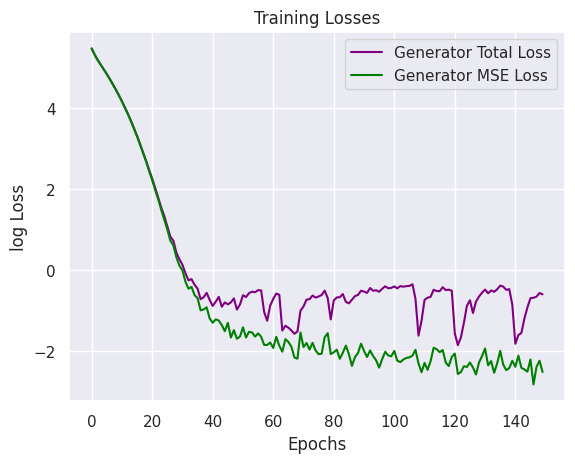

In [ ]:
loss_figure = plt.figure()

axes = plt.axes()
log_g_loss = torch.log(new_dim_gLoss)
log_MSEloss = torch.log(new_dim_mseLoss)


axes.plot(log_g_loss, label='Generator Total Loss', color='purple')
axes.plot(log_MSEloss,label='Generator MSE Loss', color='green')

plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('log Loss')
#plt.xscale("log")
plt.legend()
plt.grid(True)
plt.show()

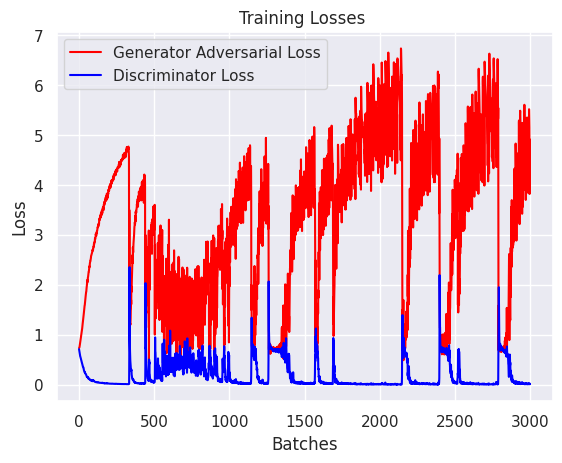

In [ ]:
loss_figure = plt.figure()

axes = plt.axes()
axes.plot(g_ADVloss_tensor, label='Generator Adversarial Loss', color='red')
axes.plot(d_loss_tensor,label='Discriminator Loss', color='blue')
plt.title('Training Losses ')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

[[[ -2.298059   -3.3750122  -4.6195455 ...   7.963259    7.7978683
     7.4707656]
  [ -2.178698   -3.4087062  -8.159849  ...   9.432579    8.0608015
     5.3090134]
  [-10.383972  -12.045652   -8.755775  ...  20.45244    19.287256
    19.356201 ]]]


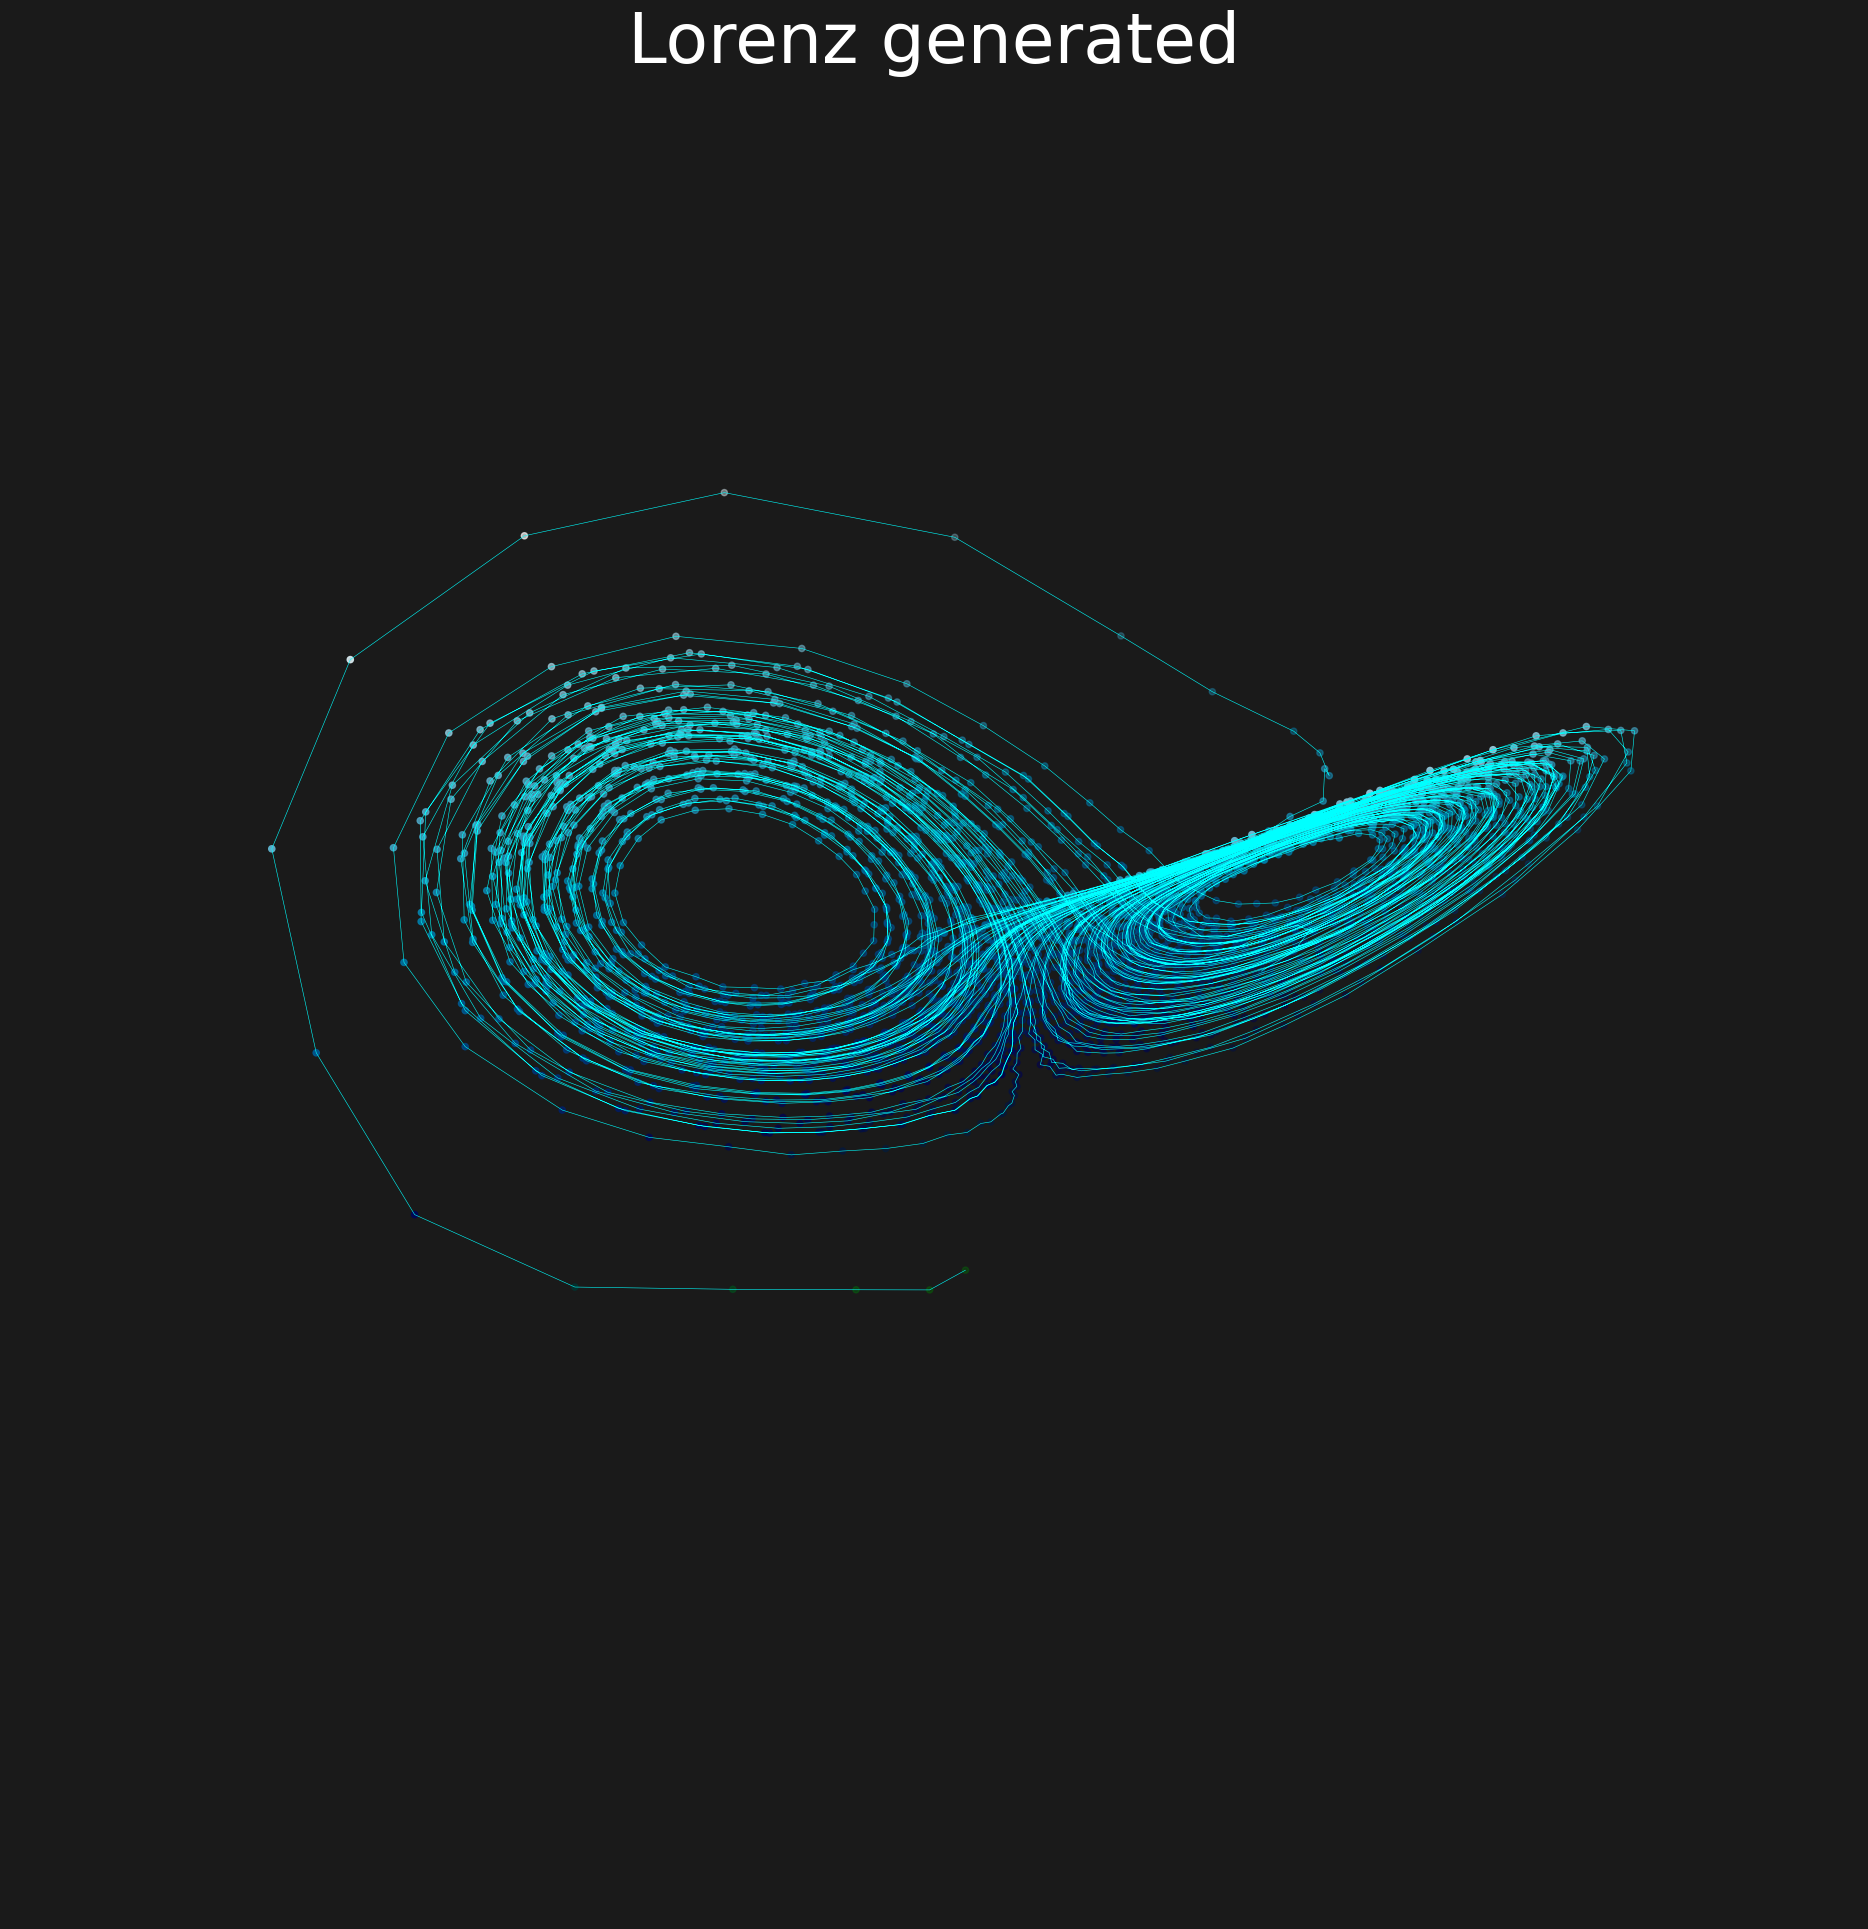

In [ ]:
sample_test_lr = test_dataset[83]['lr'].unsqueeze(0)
with torch.no_grad():
    generated_data = generator(sample_test_lr.to(device))

generated_data_np = generated_data.detach().cpu().numpy()
print(generated_data_np)
x = generated_data_np[0,0,:]
y = generated_data_np[0,1,:]
z = generated_data_np[0,2,:]

a = 5
fig = plt.figure(facecolor='k', figsize=(6.4*a, 4.8*a)) #creates figure

axes = plt.axes(projection="3d") # 3d plot area for 3d data
axes.set_facecolor('k')
axes.plot(x,y,z,'cyan', linewidth=0.4)
axes.scatter3D(x, y, z, c=z, cmap='ocean')

plt.grid(False)
plt.axis('off')
plt.title('Lorenz generated',color='white', fontsize=10*a)
plt.show()

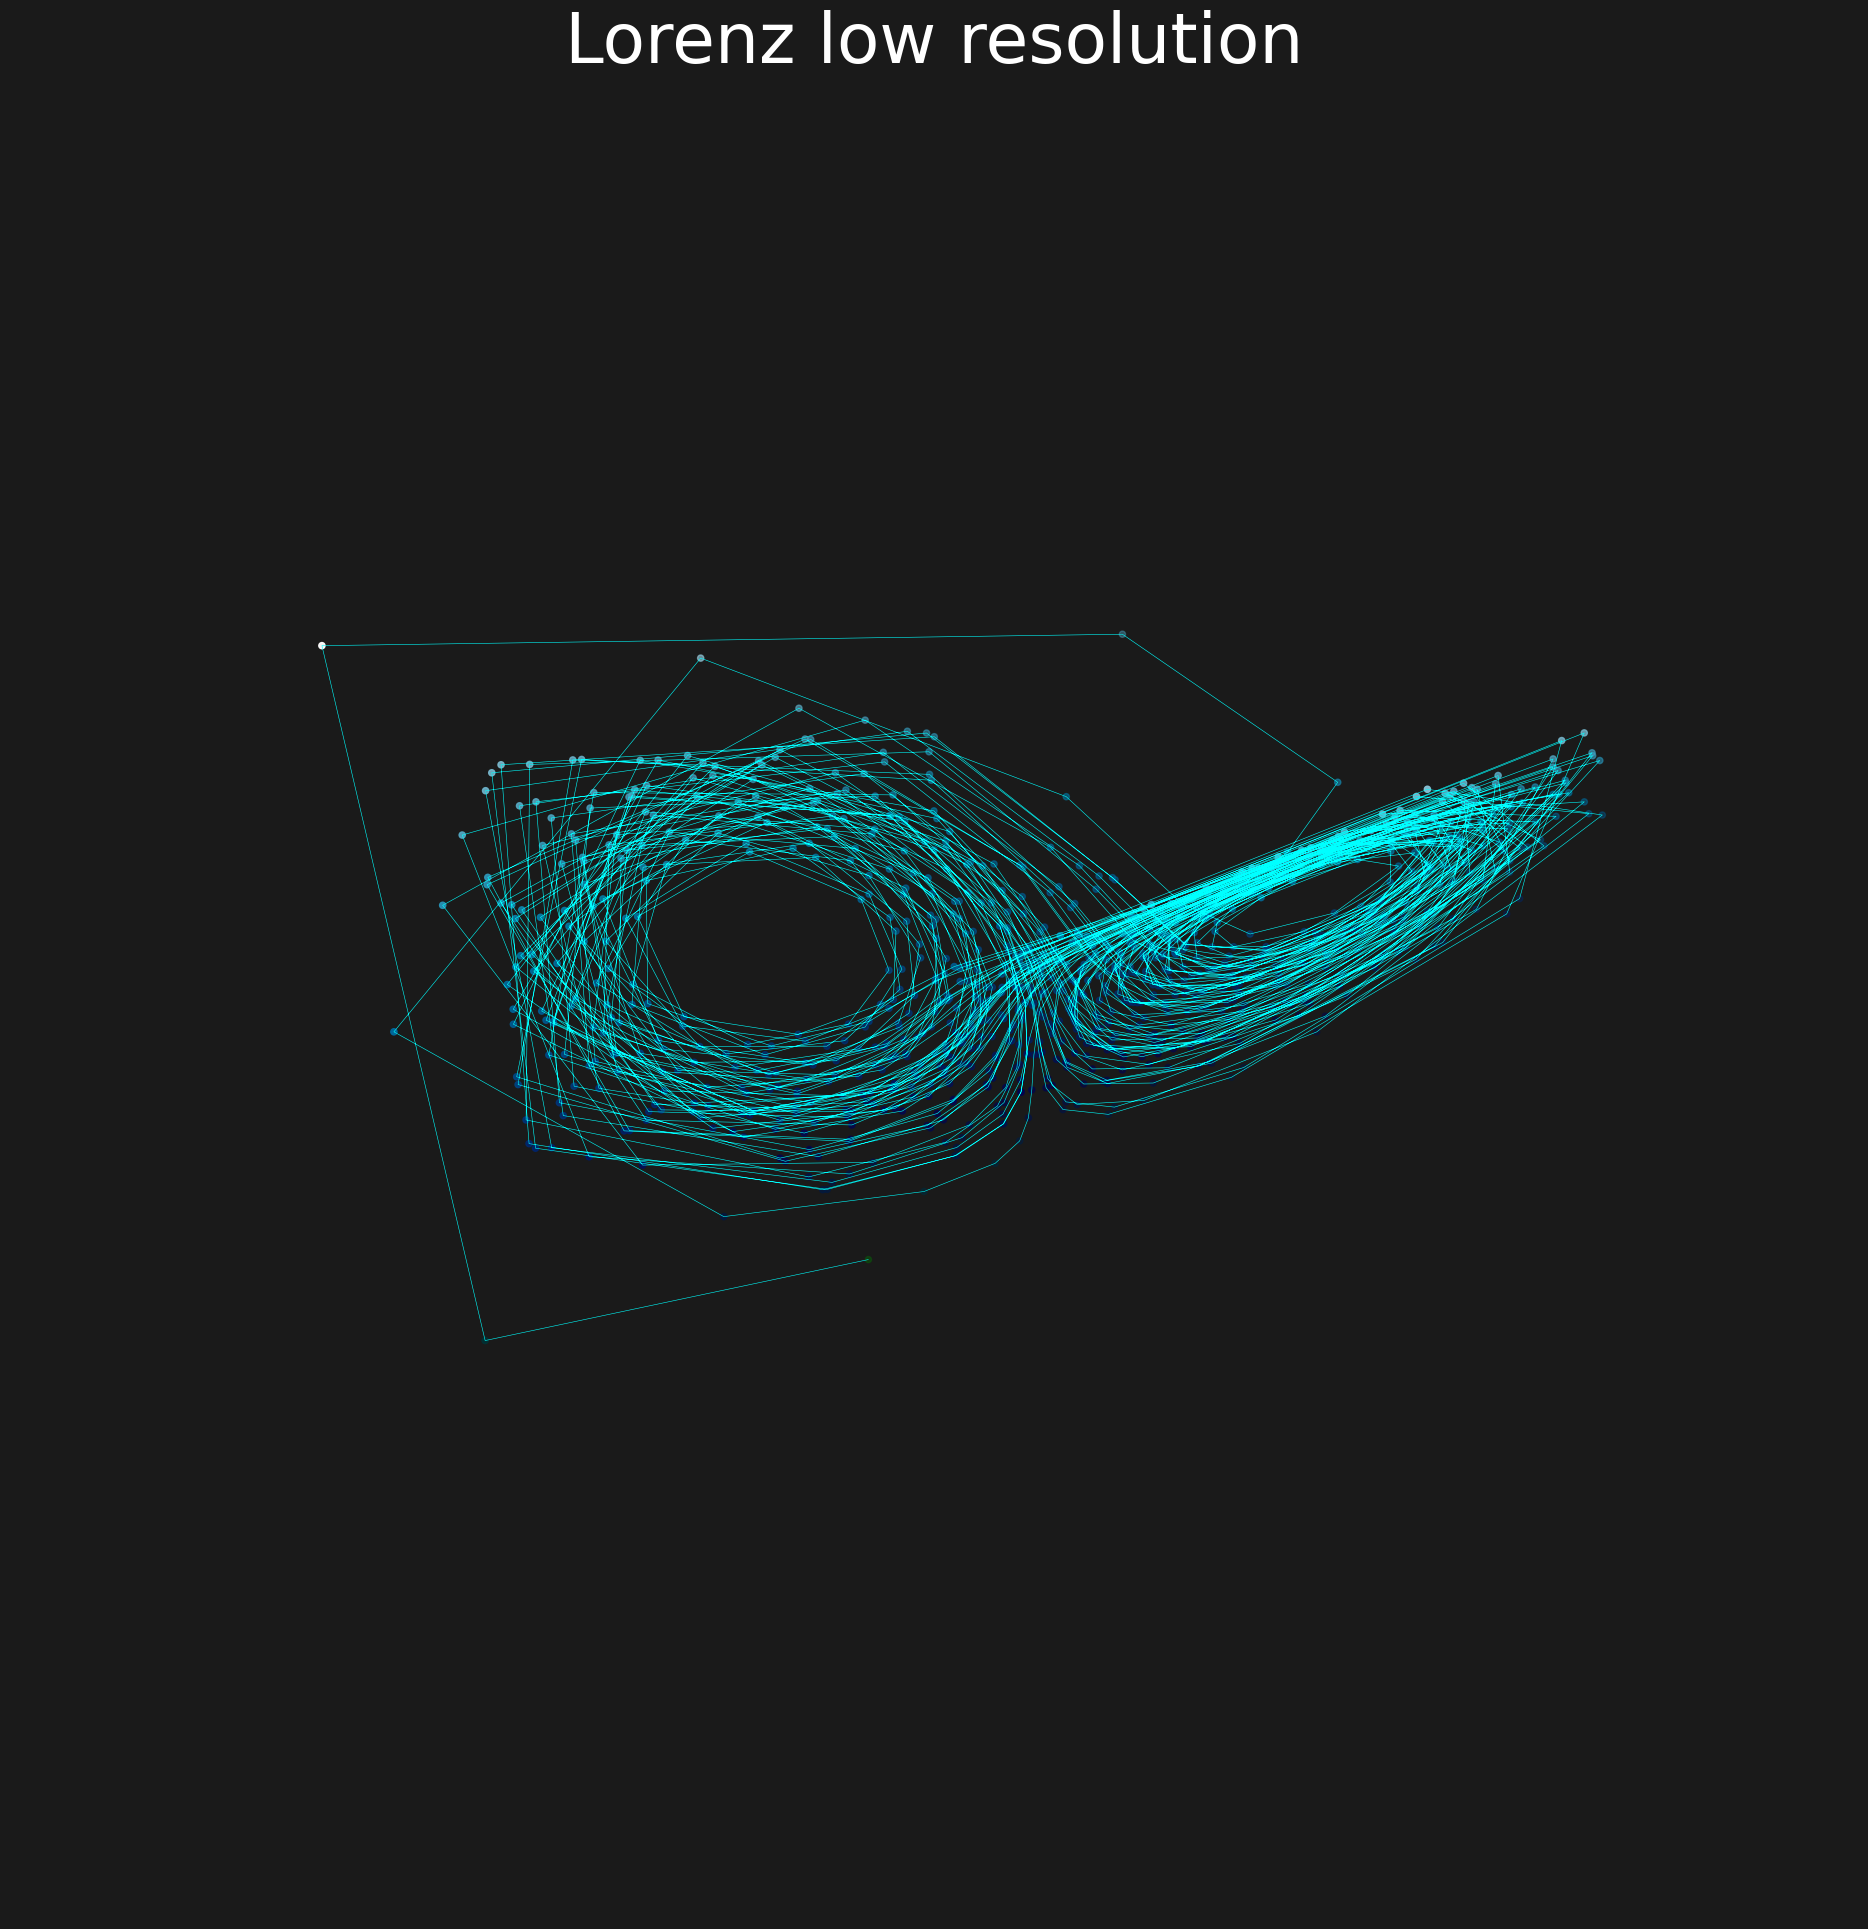

In [ ]:
sample_test_lr = test_dataset[83]['lr']
#print(sample_test_lr)
sample_test_lr_np = sample_test_lr.detach().cpu().numpy()
x_lr = sample_test_lr_np[0,:]
y_lr = sample_test_lr_np[1,:]
z_lr = sample_test_lr_np[2,:]

a = 5
fig = plt.figure(facecolor='k', figsize=(6.4*a, 4.8*a)) #creates figure

axes = plt.axes(projection="3d") # 3d plot area for 3d data
axes.set_facecolor('k')
axes.plot(x_lr,y_lr,z_lr,'cyan', linewidth=0.4)
axes.scatter3D(x_lr, y_lr, z_lr, c=z_lr, cmap='ocean')

plt.grid(False)
plt.axis('off')
plt.title('Lorenz low resolution',color='white', fontsize=10*a)
plt.show()

tensor([[ -7.5565,  -6.6973,  -7.3769,  ...,   9.1432,  10.3934,  11.6094],
        [ -0.2236,  -6.6721, -12.6179,  ...,  14.0696,  15.4030,  16.2318],
        [ -9.9913,  -8.7547,  -6.5557,  ...,  19.9541,  22.1630,  24.9664]])


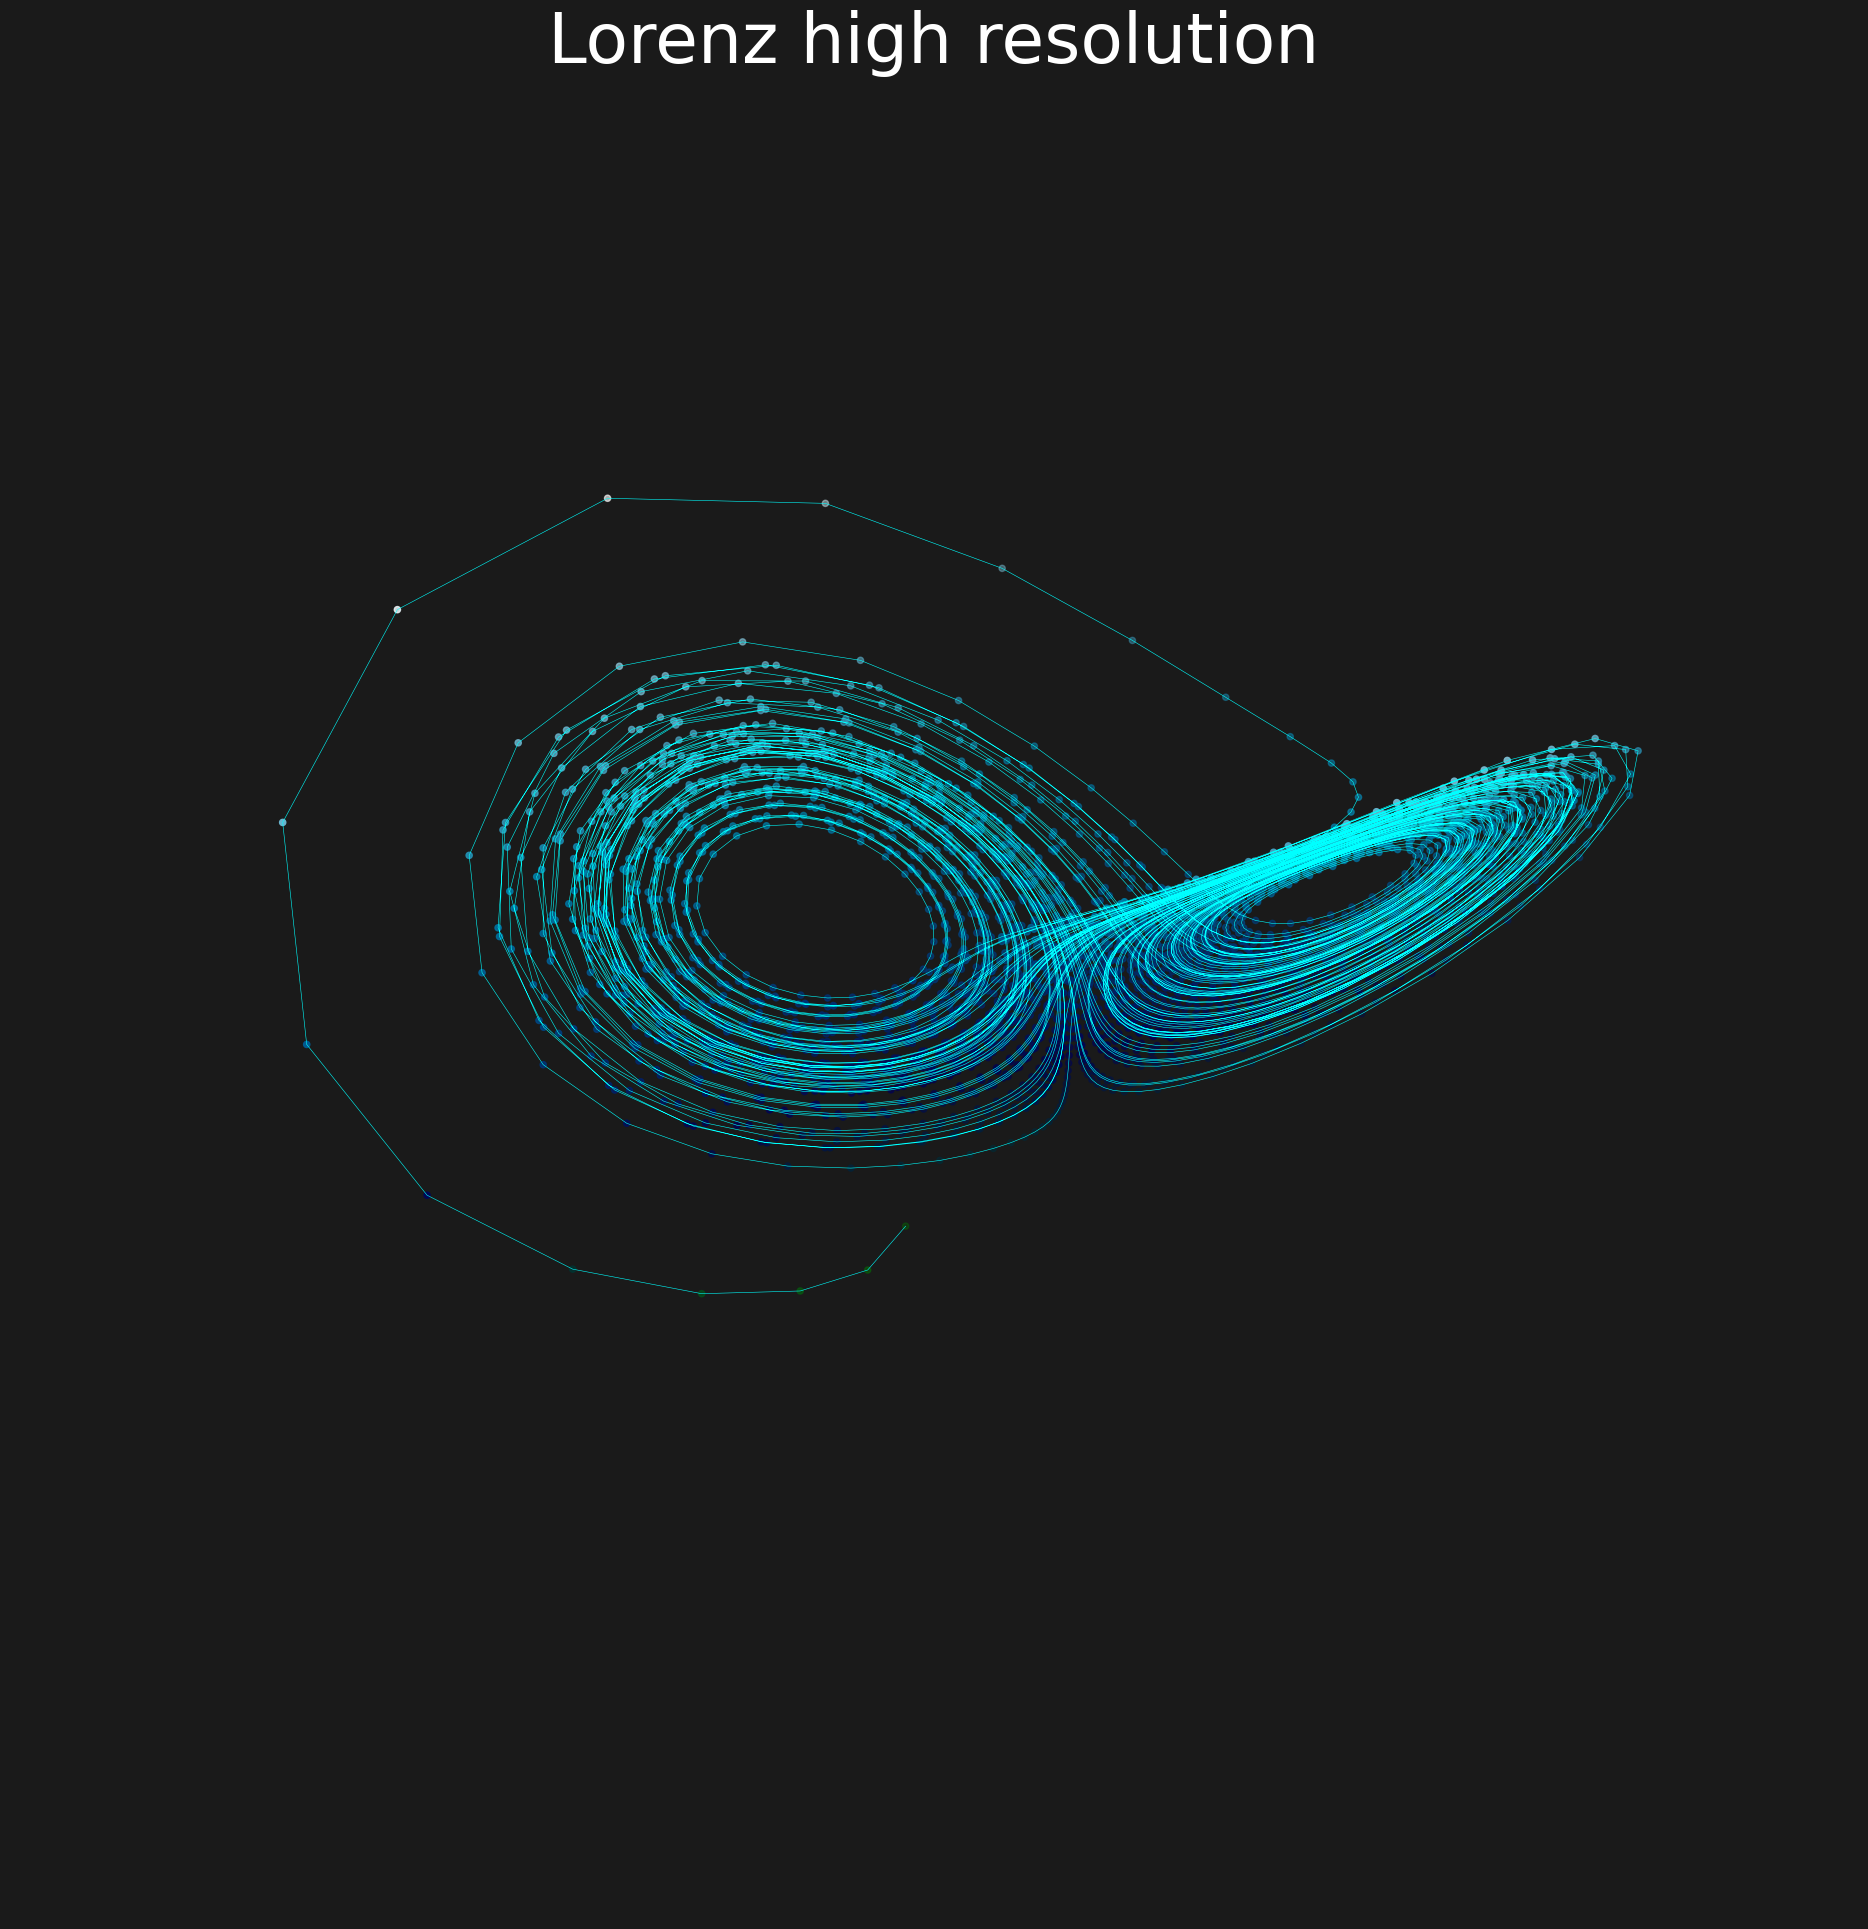

In [ ]:
sample_test_hr = test_dataset[83]['hr']
print(sample_test_hr)
sample_test_hr_np = sample_test_hr.detach().cpu().numpy()
x_real = sample_test_hr_np[0,:]
y_real = sample_test_hr_np[1,:]
z_real = sample_test_hr_np[2,:]

a = 5
fig = plt.figure(facecolor='k', figsize=(6.4*a, 4.8*a)) #creates figure

axes = plt.axes(projection="3d") # 3d plot area for 3d data
axes.set_facecolor('k')
axes.plot(x_real,y_real,z_real,'cyan', linewidth=0.4)
axes.scatter3D(x_real, y_real, z_real, c=z_real, cmap='ocean')

plt.grid(False)
plt.axis('off')
plt.title('Lorenz high resolution',color='white', fontsize=10*a)
plt.show()

In [ ]:

# test_gen = generated_data_np[0, :, ::4]
# test_high = sample_test_hr_np[:, ::4]
# print(test_gen.shape)

# print(test_gen.shape)

# print(sample_test_lr_np.shape)
# # Calculate MSE
# # Convert test_gen and test_high to PyTorch tensors
# test_gen_tensor = torch.tensor(test_gen, dtype=torch.float32)
# test_high_tensor = torch.tensor(test_high, dtype=torch.float32)
# test_lr_tensor = torch.tensor(sample_test_lr_np,dtype=torch.float32)

# mse_test = nn.MSELoss()
# loss_value = mse_test(test_high_tensor, test_gen_tensor) #compares the timepoint difference between low res and gen res(should be similar)

# print(loss_value.item())  # Get the value as a Python float



<ipython-input-18-2505dd73dc5b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hr_test_tensor = torch.tensor(hr_test,dtype=torch.float32)


[0.0641350969672203, 0.049666889011859894, 0.05671793222427368, 0.08318684250116348, 0.09124623984098434, 0.04545975103974342, 0.07585308700799942, 0.0449337400496006, 0.05421218276023865, 0.04344022646546364, 0.1783323436975479, 0.07401712238788605, 0.06422387808561325, 0.04884852468967438, 0.054473135620355606, 0.04496883973479271, 0.11281513422727585, 0.11415798962116241, 0.1213979721069336, 0.12877826392650604, 0.05789188668131828, 0.3773908019065857, 0.07836667448282242, 0.048282258212566376, 0.037966351956129074, 0.08373035490512848, 0.05692362040281296, 0.03658930957317352, 0.07884567975997925, 0.05298090726137161, 0.08450176566839218, 0.06612908840179443, 0.041365962475538254, 0.06583751738071442, 0.09468871355056763, 0.07686809450387955, 0.031956784427165985, 0.047679536044597626, 0.2724974453449249, 0.04956861957907677, 0.03360419720411301, 0.024235112592577934, 0.08128410577774048, 0.023546582087874413, 0.19558115303516388, 0.04612939432263374, 0.13257738947868347, 0.0438321

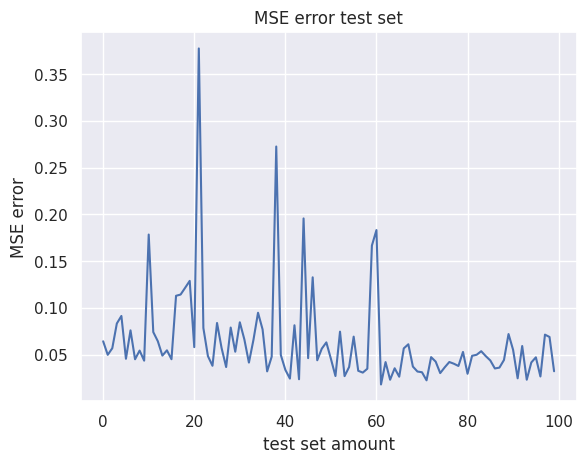

In [ ]:
#comparison with test set
#from sklearn.metrics import mean_squared_error
mse_values = []
for batch in test_loader:
    lr_test = batch['lr']  # Low resolution time series data
    hr_test = batch['hr']  # Corresponding high resolution time series data
    #lr_test_tensor = torch.tensor(lr_test,dtype=torch.float32)
    hr_test_tensor = torch.tensor(hr_test,dtype=torch.float32)

    # Generate sr
    with torch.no_grad():
        sr_test = generator(lr_test.to(device))



    sr_test_tensor = sr_test.detach().cpu()    # print(len(test_dataset))
    # print(sr_test_tensor.shape)

    # Calculate MSE for each pair of SR and HR in the batch
    for sr, hr in zip(sr_test_tensor, hr_test_tensor):
        #print(hr.shape)
        mse = loss_function_mse(sr, hr)
        mse_values.append(mse.item())

        #print(f"MSE: {mse}")

print(mse_values)

mse_average = sum(mse_values) / len(mse_values)
print(f"Average MSE: {mse_average}")

plt.title("MSE error test set")
plt.xlabel("test set amount")
plt.ylabel("MSE error")
plt.plot(mse_values)